In [1]:
#Import Client Configs
import tdAmeritradeClient
import IEXClient
import config

#Import Libs for making requests
import requests
import time
import urllib.parse as up

#Import Data Science Packages
import pandas as pd
import numpy as np
from pylab import mpl, plt
from itertools import product

In [2]:
#Plot Formatting
plt.style.use('seaborn')

In [3]:
# Create new client

In [123]:
tdClient = tdAmeritradeClient.tdAmeritradeClient(config.td_client_id, config.url)
IEXClient = IEXClient.IEXClient(config.IEX_client_id)

In [124]:
#Utility method for converting time to epoch
pattern = '%d.%m.%Y %H:%M:%S'

def epoch(date_time):
    #date_time = '29.08.2011 11:05:02'
    epoch = int(time.mktime(time.strptime(date_time, pattern)))
    return epoch

In [125]:
def getTime(epoch):
    #epoch = 1576759500000
    #epoch = 1490157520.05
    normalTime = time.strftime(pattern, time.localtime(epoch))
    return normalTime

In [46]:
#TD Ameritrade APIs

"""
Secured
- Accounts and Trading
- Transaction History
- User Info & Preferences
- Watchlist

Unsecured
- Instruments
- Market Hours
- Movers
- Option Chains
- Price History
- Quotes
"""

'\nSecured\n- Accounts and Trading\n- Transaction History\n- User Info & Preferences\n- Watchlist\n\nUnsecured\n- Instruments\n- Market Hours\n- Movers\n- Option Chains\n- Price History\n- Quotes\n'

In [47]:
#IEX APIs

#https://iexcloud.io/docs/api/#api-reference

In [76]:
#Get Historical Data
#TODO: Get Apple Data from 2010 to 6-29-2018
endpoint = 'https://cloud.iexapis.com/stable/stock/aapl/chart/5y'

resp = IEXClient.get(endpoint)

In [77]:
type(resp)

str

In [78]:
resp

'Error Making Call. API returned 402'

In [50]:
#convert data to dataframe
dataframe = pd.DataFrame(resp)
dataframe.set_index('date',inplace=True)

In [52]:
dataframe.head()

,change,changeOverTime,changePercent,close,high,label,low,open,uClose,uHigh,uLow,uOpen,uVolume,volume
date,,,,,,,,,,,,,,
2019-12-04,0.00,0.000000,0.0000,261.74,263.31,Dec 4,260.68,261.07,261.74,263.31,260.68,261.07,16810388,16810388
2019-12-05,3.84,0.014671,1.4671,265.58,265.89,Dec 5,262.73,263.79,265.58,265.89,262.73,263.79,18661343,18661343
2019-12-06,5.13,0.034271,1.9316,270.71,271.00,Dec 6,267.30,267.48,270.71,271.00,267.30,267.48,26547493,26547493
2019-12-09,-3.79,0.019791,-1.4000,266.92,270.80,Dec 9,264.91,270.00,266.92,270.80,264.91,270.00,32182645,32182645
2019-12-10,1.56,0.025751,0.5844,268.48,270.07,Dec 10,265.86,268.60,268.48,270.07,265.86,268.60,22632383,22632383


In [3]:
raw = pd.read_csv('HistoricalData/AAPL.csv')
raw.set_index('Date',inplace=True)

In [54]:
stock_hist = pd.DataFrame(raw['Close']).dropna()

In [81]:
#######################################

#First Strategy. Simple Moving Averages

#######################################

sma1 = 42
sma2 = 170

stock_hist['sma1'] = stock_hist['Close'].rolling(sma1).mean()
stock_hist['sma2'] = stock_hist['Close'].rolling(sma2).mean()

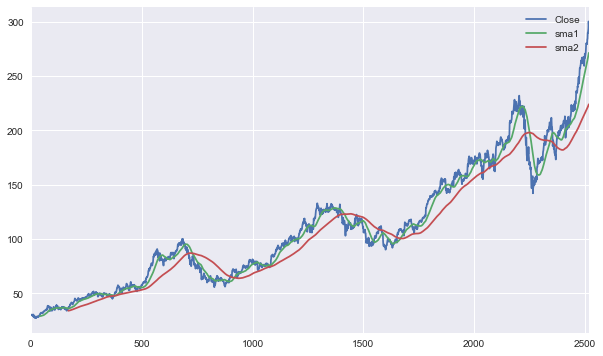

In [83]:
stock_hist.plot(y=["Close","sma1","sma2"], figsize=(10, 6))

In [84]:
stock_hist.dropna(inplace=True)
stock_hist['Position'] = np.where(stock_hist['sma1'] > stock_hist['sma2'], 1, -1)

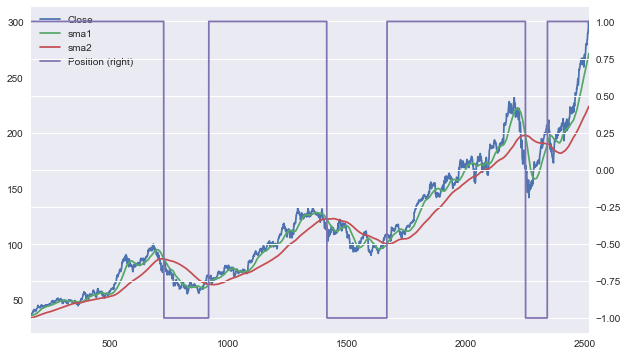

In [85]:
ax = stock_hist.plot(secondary_y='Position', figsize=(10,6))

In [86]:
#Calculate Market Returns vs Strategy Returns
stock_hist['Return'] = np.log(stock_hist['Close'] / stock_hist['Close'].shift(1))
stock_hist['Strategy'] = stock_hist['Position'].shift(1) * stock_hist['Return']

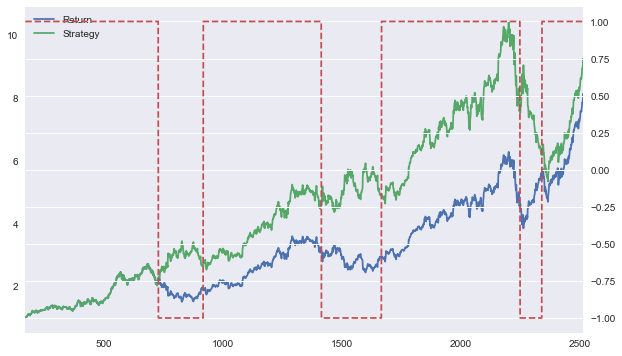

In [87]:
ax = stock_hist[['Return', 'Strategy']].cumsum().apply(np.exp).plot(figsize=(10,6)) 
stock_hist['Position'].plot(ax=ax, secondary_y='Position', style = '--')

In [63]:
#Range Parameters. Start, Stop, Step
sma1_range = range(10, 61, 4)
sma2_range = range(100, 281, 10)

In [88]:
results = pd.DataFrame()
for SMA1, SMA2 in product(sma1_range, sma2_range):
    data = pd.DataFrame(raw['Close'])
    data.dropna(inplace=True)
    data['Return'] = np.log(data['Close'] / data['Close'].shift(1))
    data['SMA1'] = data['Close'].rolling(SMA1).mean()
    data['SMA2'] = data['Close'].rolling(SMA2).mean()
    data.dropna(inplace=True)
    data['Position'] = np.where(data['SMA1'] > data['SMA2'], 1, -1)
    data['Strategy'] = data['Position'].shift(1) * data['Return']
    data.dropna(inplace=True)
    perf = np.exp(data[['Return', 'Strategy']].sum())
    results = results.append(pd.DataFrame({'SMA1': SMA1, 'SMA2': SMA2, 'MARKET': perf['Return'], 'STRATEGY': perf['Strategy'], 'OUT': perf['Strategy'] - perf['Return']}, index=[0]), ignore_index=True)

In [89]:
#Get the optimal SMA
results.sort_values('OUT', ascending=False).head(10)

,SMA1,SMA2,MARKET,STRATEGY,OUT
159,42,170,8.045793,9.153848,1.108054
142,38,190,7.472043,8.266715,0.794672
160,42,180,7.350951,8.132504,0.781553
237,58,190,7.472043,7.925947,0.453905
178,46,170,8.045793,8.340675,0.294882
238,58,200,6.547201,6.719915,0.172714
141,38,180,7.350951,7.511576,0.160625
123,34,190,7.472043,7.529013,0.056970
105,30,200,6.547201,6.513912,-0.033290
85,26,190,7.472043,7.430331,-0.041712


In [55]:
#######################################

#Deep Neural Networks

# First example will use Scikit-learn

# Second example will use TensorFlow

#######################################

In [ ]:
###################################################################################

# Scikit-learn

In [4]:
def create_lags(data, lags):
    cols = []
    for lag in range(1, lags + 1):
        col = 'lag_{}'.format(lag)
        data[col] = data['returns'].astype(float).shift(lag)
        cols.append(col)
    return cols

In [5]:
def create_bins(data, cols, bins=[0]):
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)
        cols_bin.append(col_bin)
    return cols_bin

In [6]:
data = pd.DataFrame(raw['Close'])

In [59]:
data['returns'] = np.log(data / data.shift(1))
data['direction'] = np.sign(data['returns'])

C:\Users\Mike\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sign
  


In [60]:
lags = 5
lag_cols = create_lags(data, lags)
type(cols[1])

str

In [65]:
data.dropna(inplace=True)
cols_bin = create_bins(data, lag_cols)
cols_bin

['lag_1_bin', 'lag_2_bin', 'lag_3_bin', 'lag_4_bin', 'lag_5_bin']

In [75]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [67]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=2 * [250], random_state=1)

In [68]:
%time model.fit(data[cols_bin], data['direction'])

Wall time: 6.75 s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[250, 250], learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [70]:
data['pos_dnn_sk'] = model.predict(data[cols_bin])

In [71]:
data['strat_dnn_sk'] = data['pos_dnn_sk'] * data['returns']

In [72]:
data[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns          9.909142
strat_dnn_sk    32.754346
dtype: float64

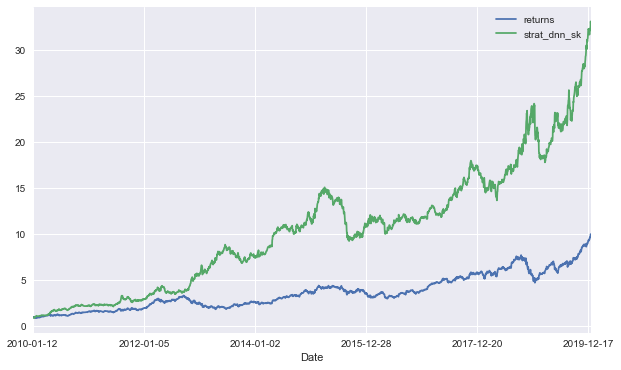

In [73]:
data[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [76]:
train, test = train_test_split(data, test_size=0.5, random_state=100)

In [77]:
train = train.copy().sort_index()

In [78]:
test = test.copy().sort_index()

In [79]:
model = MLPClassifier(solver='lbfgs', alpha=1e-5, max_iter=500, hidden_layer_sizes=3 * [500], random_state=1)

In [80]:
%time model.fit(train[cols_bin], train['direction'])

Wall time: 10.6 s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=[500, 500, 500], learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=1, shuffle=True, solver='lbfgs', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [81]:
test['pos_dnn_sk'] = model.predict(test[cols_bin])

In [82]:
test['strat_dnn_sk'] = data['pos_dnn_sk'] * test['returns']

In [83]:
test[['returns', 'strat_dnn_sk']].sum().apply(np.exp)

returns         4.111307
strat_dnn_sk    4.534023
dtype: float64

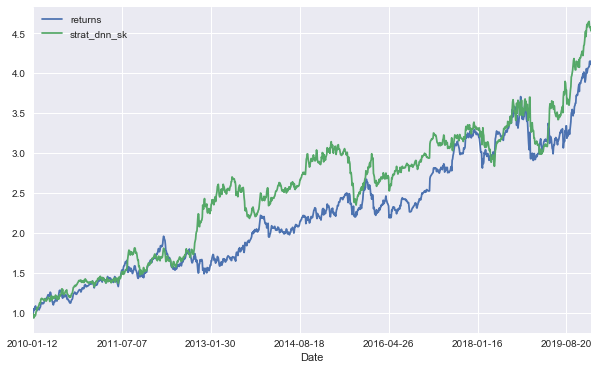

In [84]:
test[['returns', 'strat_dnn_sk']].cumsum().apply(np.exp).plot(figsize=(10, 6))

In [95]:
data = pd.DataFrame(raw['Close'])

lags = 5
cols = []
for lag in range(1, lags +1):
    col = 'lag_{}'.format(lag)
    data[col] = data['Close'].shift(lag)
    cols.append(col)
    
data.dropna(inplace=True)

In [96]:
data.describe

<bound method NDFrame.describe of            Close       lag_1       lag_2       lag_3       lag_4       lag_5
5      30.015715   30.282858   30.082857   30.138571   30.625713   30.572857
6      29.674286   30.015715   30.282858   30.082857   30.138571   30.625713
7      30.092857   29.674286   30.015715   30.282858   30.082857   30.138571
8      29.918571   30.092857   29.674286   30.015715   30.282858   30.082857
9      29.418571   29.918571   30.092857   29.674286   30.015715   30.282858
10     30.719999   29.418571   29.918571   30.092857   29.674286   30.015715
11     30.247143   30.719999   29.418571   29.918571   30.092857   29.674286
12     29.724285   30.247143   30.719999   29.418571   29.918571   30.092857
13     28.250000   29.724285   30.247143   30.719999   29.418571   29.918571
14     29.010000   28.250000   29.724285   30.247143   30.719999   29.418571
15     29.420000   29.010000   28.250000   29.724285   30.247143   30.719999
16     29.697144   29.420000   29.010000  

In [39]:
#Get Quote Information
endpoint = 'https://cloud.iexapis.com/stable/stock/aapl/quote'

resp = IEXClient.get(endpoint)


In [24]:
#Make Call to get data

#define the endpoints
endpoint = "https://api.tdameritrade.com/v1/marketdata/{}/pricehistory".format('GOOG')

#define payload
body = {'periodType':'day',
       'frequencyType':'minute',
       'frequency' : '1',
       'period': '2',
       'endDate' : epoch('26.12.2019 08:00:00'),
       'startDate' : epoch('27.12.2019 17:00:00')}

content = tdClient.get(url = endpoint, body = body)

print(content)


{'candles': [{'open': 1353.1, 'high': 1353.1, 'low': 1353.1, 'close': 1353.1, 'volume': 180, 'datetime': 1576759500000}, {'open': 1353.1, 'high': 1353.1, 'low': 1353.1, 'close': 1353.1, 'volume': 294, 'datetime': 1576759860000}, {'open': 1353.1, 'high': 1353.1, 'low': 1353.1, 'close': 1353.1, 'volume': 500, 'datetime': 1576760160000}, {'open': 1352.0, 'high': 1352.0, 'low': 1352.0, 'close': 1352.0, 'volume': 100, 'datetime': 1576765680000}, {'open': 1351.82, 'high': 1355.5, 'low': 1351.0, 'close': 1355.5, 'volume': 12957, 'datetime': 1576765800000}, {'open': 1355.72, 'high': 1357.74, 'low': 1355.72, 'close': 1357.66, 'volume': 2808, 'datetime': 1576765860000}, {'open': 1357.78, 'high': 1357.94, 'low': 1357.1, 'close': 1357.8686, 'volume': 2995, 'datetime': 1576765920000}, {'open': 1358.0, 'high': 1358.1, 'low': 1357.13, 'close': 1357.13, 'volume': 4277, 'datetime': 1576765980000}, {'open': 1356.99, 'high': 1357.15, 'low': 1356.6306, 'close': 1356.6306, 'volume': 2200, 'datetime': 15767

In [25]:
df = pd.DataFrame(content.get('candles'))

In [26]:
#API Call to get movers

#The index symbol to get movers from. Can be $COMPX, $DJI, or $SPX.X. Click to edit the value.
endpoint = 'https://api.tdameritrade.com/v1/marketdata/{}/movers'.format('$DJI')

#Query Params
params = 'direction=up&change=percent'

movers = tdClient.get(url = endpoint, queryParams = params)

print(movers)


[{'change': 0.00853937046966537, 'description': 'Nike, Inc. Common Stock', 'direction': 'up', 'last': 101.57, 'symbol': 'NKE', 'totalVolume': 8454855}, {'change': 0.006947771921418339, 'description': 'Procter & Gamble Company (The) Common Stock', 'direction': 'up', 'last': 126.09, 'symbol': 'PG', 'totalVolume': 10652742}, {'change': 0.005997818974918179, 'description': 'Coca-Cola Company (The) Common Stock', 'direction': 'up', 'last': 55.35, 'symbol': 'KO', 'totalVolume': 11418983}, {'change': 0.005632802192225642, 'description': "McDonald's Corporation Common Stock", 'direction': 'up', 'last': 198.17, 'symbol': 'MCD', 'totalVolume': 4008934}, {'change': 0.0043463724506853565, 'description': 'Intel Corporation - Common Stock', 'direction': 'up', 'last': 60.08, 'symbol': 'INTC', 'totalVolume': 14086205}, {'change': 0.003915810083210997, 'description': 'Verizon Communications Inc. Common Stock', 'direction': 'up', 'last': 61.53, 'symbol': 'VZ', 'totalVolume': 17193518}, {'change': 0.0037

In [7]:
#Accessing authorization information

#auth.get('access_token')
#auth.get('refresh_token_expires_in')
#auth.get('scope')
#auth.get('expires_in')

In [12]:
#Make secured call to get accounts and account info

endpoint = "https://api.tdameritrade.com/v1/accounts"

accounts = tdClient.secureGet(endpoint)